# Updated SEM for Salinity Gradient Paper
## By Cliff Bueno de Mesquita, December 2022
- Use Wyatt's code from "SEM for SF OTU guilds test v0.7 x v0.13 -- FOR PLOTTING LASSO 12aug2020.ipynb" file
- Run first part (to cell 38) of that and save data in SEM/data for use here
- Get custom functions for analyzing SEMs from there too
- Specify same SEM as old Figure 5 but with new SILVA data and Guilds
- Update model results and figure
- Try some alternative models because Figure 5a updated model was no longer significant

## 1. Setup

In [162]:
# Directory
setwd("~/Documents/GitHub/SF_microbe_methane/sem/")

In [81]:
# Libraries
library(ggplot2)
library(RColorBrewer)
library(reshape2)
suppressMessages(library(corrplot))
suppressMessages(library(Hmisc))
suppressMessages(library(cowplot))
theme_set(theme_grey())
library("stringr") 
suppressWarnings(library("DiagrammeR"))
library("semPlot")
suppressMessages(suppressWarnings(library("lavaan")))
suppressMessages(library("dplyr"))
library(AICcmodavg)
library(corrplot)

In [82]:
# Wyatt's Functions
sem_fit_params <- c( "pvalue", "chisq", "df", "npar","aic", "bic", "gfi", "cfi", "rni", "rmsea", "srmr")

get_SEM_nonsig_vars = function(sem_mod, p_cut) {

    # get significant only 
    sem_params <- parameterEstimates(sem_mod)                          # Get estimates
    sem_params_bad <- sem_params[sem_params$pvalue > p_cut,]           # cut out significant

    # clean up
    keep <- c('lhs', 'op','rhs','pvalue')                              # params to keep
    sem_params_bad <- sem_params_bad[keep]                             # keep
    sem_params_bad$pvalue <- round(sem_params_bad$pvalue, 2)           #  round p value
    sem_params_bad <- sem_params_bad[complete.cases(sem_params_bad),]  # drop all NA values (comes up in latent mods)

    return(sem_params_bad)
    
}

get_SEM_R2s = function(sem_mod){
    
    sem_name <- paste(as.character(deparse(substitute(sem_mod))))
    model <- data.frame(model = sem_name)
    
    R2s <- inspect(sem_mod, 'r2')
    R2s <- data.frame(round(R2s, 3))
    out <- t(R2s)
    
    out <- data.frame(model, out)
    row.names(out) <-NULL
    return(out)
}

sem_fit_sum = function(sem_mod, sem_fit_params) {
    
    sem_name <- paste(as.character(deparse(substitute(sem_mod))))
    model <- data.frame(model = sem_name)
    
    fits <- data.frame(fitMeasures(sem_mod, sem_fit_params))
    fits <- round(fits, digits = 3)
    out <- t(fits)
    
    out <- data.frame(model, out)
    row.names(out) <-NULL
   # names(out)[1] <- sem_name
    return(out)
    
    
}

compare_sem_fits = function(models, sem_fit_params){
    
    out_list <- {}
    
    for (i in seq_along(models)) {

        curr_mod <- get(models[[i]])
        out_list[[i]] <- sem_fit_sum(curr_mod, sem_fit_params)

        }

    out <- do.call("rbind", out_list)
    out$model <- models
    return(out)
    
}

compare_sem_R2s = function(models){
    
    out_list <- {}
    
    for (i in seq_along(models)) {

        curr_mod <- get(models[[i]])
        R2c <- get_SEM_R2s(curr_mod)
        R2c$model <- models[i]
        out_list[[i]] <- R2c
        #out_list[[i]] <- get_SEM_R2s(curr_mod)
        #names(out_list[i]) <- models[i]
        }
    
    out <- Reduce(function(...) merge(..., all=T), out_list)
    
    #out <- Reduce(merge, out_list)
    #out <- do.call("rbind", out_list)
    #out$model <- models
    #out_list
    out
}
                  
compare_sem_results = function(models, sem_fit_params){
    
        fits <- compare_sem_fits(models, sem_fit_params)
        R2s <- compare_sem_R2s(models)
    
        out <- data.frame(cbind(fits, R2s[,-1]))
        #out <- data.frame(merge(fits, R2s, by="model"))
        return(out)

}
                  
sem_mi_table <- function(sem_mod, mi_lower = 4, mi_sort = "T", head = "T"){
    
    mi_tab <- data.frame(modindices(sem_mod))  # get mod indices table
    mi_tab <- mi_tab[mi_tab$mi > mi_lower,]         # impose cutoff on lower MI 
    
    # sort by mi?  or defaults to covariances first
    if (mi_sort == "T") {out_tab <- mi_tab[order(-mi_tab$mi),]}
        else {out_tab <- mi_tab}
    
    # crop to top 5 most important effects?
    if (head == "T") {out <- head(out_tab)}
        else {out <- out_tab}
    
    return(out)
        
}

get_sem_covariances = function(sem_mod, n_res =5){  # output_factors = F - consider output as list not table?
    
    # Get covariance matrix, melt
    resid <- residuals(sem_mod)$cov
    resid[lower.tri(resid, diag = T)] <-0         # get upper triangle only, lower as 0
    resid_M <- melt(resid)                        # melt DF

    # Clean, sort table
    resid_M <- resid_M[!resid_M$value == 0,]      # Drop 0/lower
    resid_M$abs <- abs(resid_M$value)             # Get abs for sorting effect size 
    resid_M <- resid_M[order(-resid_M$abs),]      # sort by abs
    resid_M <- resid_M[,1:3]                      # drop abs col 
    resid_M <- resid_M[1:n_res,]                  # get first n results
    resid_M
              
}
                  
plot_matrix <- function(matrix_toplot){
corrplot(matrix_toplot, is.corr = FALSE, 
               type = 'lower', 
               order = "original", 
               tl.col='black', tl.cex=.75)
}
                  
get_mi_covars_pair = function(data, r_cut = 0.5, keep_pair){
    
    corr_m <- cor(data)                                             # get corr
    corr_m[abs(corr_m) < r_cut] <- NA                               # get abs value over threshold only, or NA

    select_cols <- data.frame(corr_m[,keep_pair])                   # Get only cols from MI inputs
    # select_cols <- data.frame(corr_m[,keep_vars])                 -- too many vars at once not helping
    common_data <- t(select_cols[complete.cases(select_cols),])        # get only complete cases -- no NA
    common_data <- round(common_data,2)
    #select_cols
    common_data
}
                  
get_mi_covars_many = function(data, r_cut = 0.5, keep_vars){
    
    corr_m <- cor(data)                                             # get corr
    corr_m[abs(corr_m) < r_cut] <- NA                               # get abs value over threshold only, or NA

    # select_cols <- data.frame(corr_m[,keep_pair])                 # Get only cols from MI inputs
    select_cols <- data.frame(corr_m[,keep_vars])                   #  too many vars at once not helping
    # common_data <- select_cols[complete.cases(select_cols),]      # get only complete cases -- no NA
    common_data <- t(select_cols[rowSums(is.na(select_cols)) != ncol(select_cols), ])
    common_data <- round(common_data,2)
    common_data
}
                  
define_new_sem_table <- function(mod_name, response_vars, output_prefix = "sem."){

    # Build data frame of sub-formulas from names (not working so manually do). Note need version for 5, 7 and 9 vars
    #feat_list <- {}
    #for (i in length(response_vars)) {
#
 #       feat_list[[i]] <- get(response_vars[i])
#
 #   }
    feat_list <- list()
    feat_list[[1]] <- get(response_vars[1])
    feat_list[[2]] <- get(response_vars[2])
    feat_list[[3]] <- get(response_vars[3])
    feat_list[[4]] <- get(response_vars[4])
    feat_list[[5]] <- get(response_vars[5])
    if (length(response_vars) == 7) {
        feat_list[[6]] <- get(response_vars[6])
        feat_list[[7]] <- get(response_vars[7])
}
    if (length(response_vars) == 9) {
        feat_list[[6]] <- get(response_vars[6])
        feat_list[[7]] <- get(response_vars[7])
        feat_list[[8]] <- get(response_vars[8])
        feat_list[[9]] <- get(response_vars[9])
}
    
    feats <- data.frame(feat_list)
    names(feats) <- response_vars
#    row.names(feats) <- response_vars
#    feats <-data.frame(t(feats))
              
    # Get model formula from feats
    formula <- do.call(paste, c(feats, sep = '\n'))
    feats$formula <- formula
     
    # add model info
    model_out <- paste0(output_prefix, mod_name)
    mod_info <- data.frame(model_out = model_out, model = mod_name, base = mod_name, notes = "base")
    
    out <- data.frame(mod_info, feats)
    row.names(out) <- NULL
    return(out)
        
}
                  
update_sem_model_table = function(mod_table, base_model, new_mod_name, notes, formula_edits, 
                                  output_prefix = "sem.", 
                                  non_feat_cols = c("model_out","model", "base", "notes", "formula")){
    
     # copy base model & update descriptions
     new_model <- mod_table[mod_table$model == base_model,]
     new_model$base <- base_model
     new_model$model <- new_mod_name
     new_model$model_out <- paste0(output_prefix, new_mod_name) 
     new_model$notes <- notes
    
     # edit formula components
     form_feat <- formula_edits[1]
     form_edit <- formula_edits[2]
    
     new_model[form_feat] <- form_edit
    
     # rebuild full formula
     cols <- names(new_model)
     feat_cols <- cols[!cols %in% non_feat_cols]
     feats <- data.frame(new_model[feat_cols])
                         
     formula <- do.call(paste, c(feats, sep = '\n'))
     new_model$formula <- formula
    
     # append to original table 
     mod_table_updated <- rbind(mod_table, new_model)
                 
     mod_table_updated
     #new_model
}
                  
sem_table_run_assign = function(sem_mod_table, data, estimator = 'mlm', prefix = "sem."){

        iters <- nrow(sem_mod_table)                                                  # seq_along misbehaving, use iters for loop
    
        for(i in seq(1:iters)) {
         
            # run SEM model            
            curr_model <- sem_mod_table$formula[i]                                    # get ith sem formula
            sem <- sem(curr_model, data=data, fixed.x=FALSE, estimator = estimator, orthogonal =TRUE)   # run SEM; fixed.x not working in fxn
            
            # assign mod_out names to models (GLOBAL ENV)
            sem_name <- paste(sem_mod_table$model_out[i])                             # get model name from model_out
            assign(sem_name, sem, envir=.GlobalEnv)                                   # assign to global env 
        }
        
        # Gather models run and print list to console
        models_run <- paste(sem_mod_table$model_out, collapse =', ')
        print(paste0("ran SEM to create models: ", models_run))
        
        models_run_out_list <- c(paste(sem_mod_table$model_out))
        models_run_out_list
    
}      
                  
run_compare_sem_models = function(mod_table, data, estimator = "mlm", 
                                  keep_mod_descr = c("model_out","model", "base", "notes"),
                                  sem_fit_params = c("pvalue", "chisq", "df", "npar","aic", "bic", 
                                                      "gfi", "cfi", "rni", "rmsea", "srmr")){
    
    # note mod_table requires columns: model, model_out, formula cols 
    
    # get model table features to include in summary
    mod_descr <- data.frame(mod_table[keep_mod_descr])
    mod_descr
    
    # run assign SEM models in table 
    sem_out_list <- sem_table_run_assign(mod_table, data, estimator)
    #sem_out_list

    # Get SEM results summary as previously
    fit_summary <- data.frame(compare_sem_results(sem_out_list, sem_fit_params))
    
    
    # Clean data summary
    names(fit_summary)[1] <- "model_out"
    fit_summary$chisq <- round(fit_summary$chisq, digits = 1)
    fit_summary$aic <- round(fit_summary$aic, digits = 1)
    fit_summary$bic <- round(fit_summary$bic, digits = 1)
    #fit_summary
    
    # combine model descriptions and fits
    out <- merge(mod_descr, fit_summary, by = "model_out")
    out
    #mod_descr
    #fit_summary
}

clean_SEM_models_for_output = function(models, models_out){
    
    ### Clean up models ####  
    models <- models[, -ncol(models)]                           # drop formula column  
    models <- models[, -1]                                      # drop model out columns

    # Hide predictors in formulas
    models$CH4 <- gsub("  ", " ", models$CH4)                   # Note there are double spaces in some, likely result of replace ~.
    models$CH4 <- gsub("CH4_ug_m2_h ~ ", "", models$CH4)        # hide predictor

    models$CH4_H2 <- gsub("  ", " ", models$CH4_H2)             # remove double spaces
    models$CH4_H2 <- gsub("CH4_H2~ ", "", models$CH4_H2)        # hide predictor     

    models$MOB_I <- gsub("MOB_I ~ ", "", models$MOB_I)        

    models$MOB_IIa <- gsub("  ", " ", models$MOB_IIa)           # remove double spaces
    models$MOB_IIa <- gsub("MOB_IIa ~ ", " ", models$MOB_IIa)   # hide predictor          
    # return(models)
    
    # Merge with results
    results_tab <- merge(models_out, models, by = c('model', 'base', 'notes'))
    return(results_tab)
}
                  


In [150]:
# Data (all and Delta only)
Guild_CH4 <- read.table("~/Documents/GitHub/SF_microbe_methane/data/SEM_data/SEM_base_log2_10_all_guild_soil_data.txt")
dim(Guild_CH4)
head(Guild_CH4)

Guild_CH4_d <- read.table("~/Documents/GitHub/SF_microbe_methane/data/SEM_data/SEM_base_log2_10_delta_guild_soil_data.txt")
dim(Guild_CH4_d)
head(Guild_CH4_d)

Guild_CH4_b <- read.table("~/Documents/GitHub/SF_microbe_methane/data/SEM_data/SEM_base_log2_10_bay_guild_soil_data.txt")
dim(Guild_CH4_b)
head(Guild_CH4_b)

[1] 152  51

,Sample,CH4_ug_m2_h,CH4_logn1,CO2_mg_m2_h,CH4_CO2,Bulk_dens,H2O_FPS,pH,C,N,⋯,Actino,Chlorf,Firmic,AO_NOB,NOB_AO,mcr_pmo,pmo_mcr,CH4_all,CH4_ac_mix,MOB_all
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Browns_ThreeSqA_D1,0.472344434,0.5218678,1.05517851,-1.582834,-0.4475316,1.871870,0.7958800,0.9127533,-0.2225732,⋯,14.71778,15.35749,12.03718,0.84482076,-0.84482076,-7.514671,7.514671,8.781141,7.927983,15.01202
2,Browns_ThreeSqA_D2,0.472344434,0.5218678,1.05517851,-1.582834,-0.4304467,1.863437,0.7817554,0.8561244,-0.3010300,⋯,14.69337,15.54305,13.06765,0.14351626,-0.14351626,-6.797039,6.797039,10.377120,9.275425,16.22609
3,Browns_ThreeSqB_D1,0.005190917,0.1368549,0.56450338,-1.559312,-0.4583895,1.876980,0.7944880,0.9227255,-0.2276783,⋯,14.94039,15.21020,11.94527,0.90191500,-0.90191500,-8.156083,8.156083,7.841561,6.998851,14.98501
4,Browns_ThreeSqB_D2,0.005190917,0.1368549,0.56450338,-1.559312,-0.3957837,1.844697,0.7730547,0.8082110,-0.3381873,⋯,13.90484,15.60783,11.73935,-0.09574985,0.09574985,-7.037079,7.037079,9.102746,7.576630,15.48129
7,Browns_TuleA_D2,0.038122722,0.1614124,0.03842647,-1.000304,-0.3031784,1.842354,0.7589119,0.7315888,-0.4100504,⋯,14.94913,15.50704,13.57540,-0.06451276,0.06451276,-6.886575,6.886575,9.626566,8.506827,15.57561
8,Browns_TuleB_D1,0.267422593,0.3442878,0.43166113,-1.164239,-0.4105685,1.864015,0.7817554,0.8591383,-0.2806687,⋯,13.98774,15.13678,10.42214,0.75954597,-0.75954597,-9.528989,9.528989,5.433031,4.673630,13.67311


[1] 65 51

,Sample,CH4_ug_m2_h,CH4_logn1,CO2_mg_m2_h,CH4_CO2,Bulk_dens,H2O_FPS,pH,C,N,⋯,Actino,Chlorf,Firmic,AO_NOB,NOB_AO,mcr_pmo,pmo_mcr,CH4_all,CH4_ac_mix,MOB_all
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Browns_ThreeSqA_D1,0.472344434,0.5218678,1.05517851,-1.582834,-0.4475316,1.871870,0.7958800,0.9127533,-0.2225732,⋯,14.71778,15.35749,12.03718,0.84482076,-0.84482076,-7.514671,7.514671,8.781141,7.927983,15.01202
2,Browns_ThreeSqA_D2,0.472344434,0.5218678,1.05517851,-1.582834,-0.4304467,1.863437,0.7817554,0.8561244,-0.3010300,⋯,14.69337,15.54305,13.06765,0.14351626,-0.14351626,-6.797039,6.797039,10.377120,9.275425,16.22609
3,Browns_ThreeSqB_D1,0.005190917,0.1368549,0.56450338,-1.559312,-0.4583895,1.876980,0.7944880,0.9227255,-0.2276783,⋯,14.94039,15.21020,11.94527,0.90191500,-0.90191500,-8.156083,8.156083,7.841561,6.998851,14.98501
4,Browns_ThreeSqB_D2,0.005190917,0.1368549,0.56450338,-1.559312,-0.3957837,1.844697,0.7730547,0.8082110,-0.3381873,⋯,13.90484,15.60783,11.73935,-0.09574985,0.09574985,-7.037079,7.037079,9.102746,7.576630,15.48129
5,Browns_TuleA_D2,0.038122722,0.1614124,0.03842647,-1.000304,-0.3031784,1.842354,0.7589119,0.7315888,-0.4100504,⋯,14.94913,15.50704,13.57540,-0.06451276,0.06451276,-6.886575,6.886575,9.626566,8.506827,15.57561
6,Browns_TuleB_D1,0.267422593,0.3442878,0.43166113,-1.164239,-0.4105685,1.864015,0.7817554,0.8591383,-0.2806687,⋯,13.98774,15.13678,10.42214,0.75954597,-0.75954597,-9.528989,9.528989,5.433031,4.673630,13.67311


[1] 87 51

,Sample,CH4_ug_m2_h,CH4_logn1,CO2_mg_m2_h,CH4_CO2,Bulk_dens,H2O_FPS,pH,C,N,⋯,Actino,Chlorf,Firmic,AO_NOB,NOB_AO,mcr_pmo,pmo_mcr,CH4_all,CH4_ac_mix,MOB_all
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,China_Bullhead_CordA_D1,0.2317308,0.3145886,-0.3154709,-0.4527984,-0.2912467,1.888467,0.8543060,0.3783979,-0.6270880,⋯,16.05880,15.67667,12.69341,5.225856,-5.225856,-8.828136,8.828136,4.876297,4.189588,13.01772
2,China_Bullhead_CordA_D2,0.2317308,0.3145886,-0.3154709,-0.4527984,-0.2496557,1.858607,0.8488047,0.4149733,-0.6736641,⋯,15.10172,17.08940,15.21493,3.505465,-3.505465,-7.527117,7.527117,6.136306,4.254398,12.70387
3,China_Bullhead_CordB_D1,0.2546916,0.3336474,-0.1613991,-0.5839093,-0.2696716,1.840355,0.8627275,0.3404441,-0.6695862,⋯,16.29890,16.50102,13.71160,5.381346,-5.381346,-7.627899,7.627899,6.434937,5.749119,12.89159
4,China_Bullhead_CordB_D2,0.2546916,0.3336474,-0.1613991,-0.5839093,-0.2316346,1.808349,0.8475727,0.3692159,-0.7144427,⋯,14.64903,17.41939,13.99588,5.966672,-5.966672,-10.515178,10.515178,4.651358,4.401244,12.51518
5,China_Bullhead_CordC_D1,0.3244838,0.3925875,-0.3156161,-0.3599001,-0.2732910,1.854436,0.8573325,0.3463530,-0.6615435,⋯,15.69335,16.44907,13.56438,5.053309,-5.053309,-9.522022,9.522022,5.029818,4.115544,12.79510
6,China_Bullhead_CordC_D2,0.3244838,0.3925875,-0.3156161,-0.3599001,-0.2794368,1.858960,0.8469553,0.4149733,-0.6882461,⋯,14.99440,17.28789,14.26639,5.394224,-5.394224,-7.241586,7.241586,7.221043,6.504836,12.52403


## 2. Original Figure 5 SEMS
- All data SEM (original figure 5a)
- Delta SEM (original figure 5b)

lavaan 0.6-11 ended normally after 71 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        15
                                                      
  Number of observations                           152
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                42.007      44.420
  Degrees of freedom                                15          15
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  0.946
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ch4at_1.sem,0,42.007,15,15,1513.703,1559.061,0.982,0.951,0.951,0.109,0.03


model,CH4_logn1,CH4_ac,MOB_IIa
<chr>,<dbl>,<dbl>,<dbl>
ch4at_1.sem,0.606,0.69,0.759


,lhs,op,rhs,pvalue
,<chr>,<chr>,<chr>,<dbl>
2,CH4_logn1,~,CH4_ox,0.13
5,CH4_ac,~,H2O_FPS,0.41
10,CH4_ox,<~,Bulk_dens,0.17
12,MOB_IIa,~,AOA,0.10


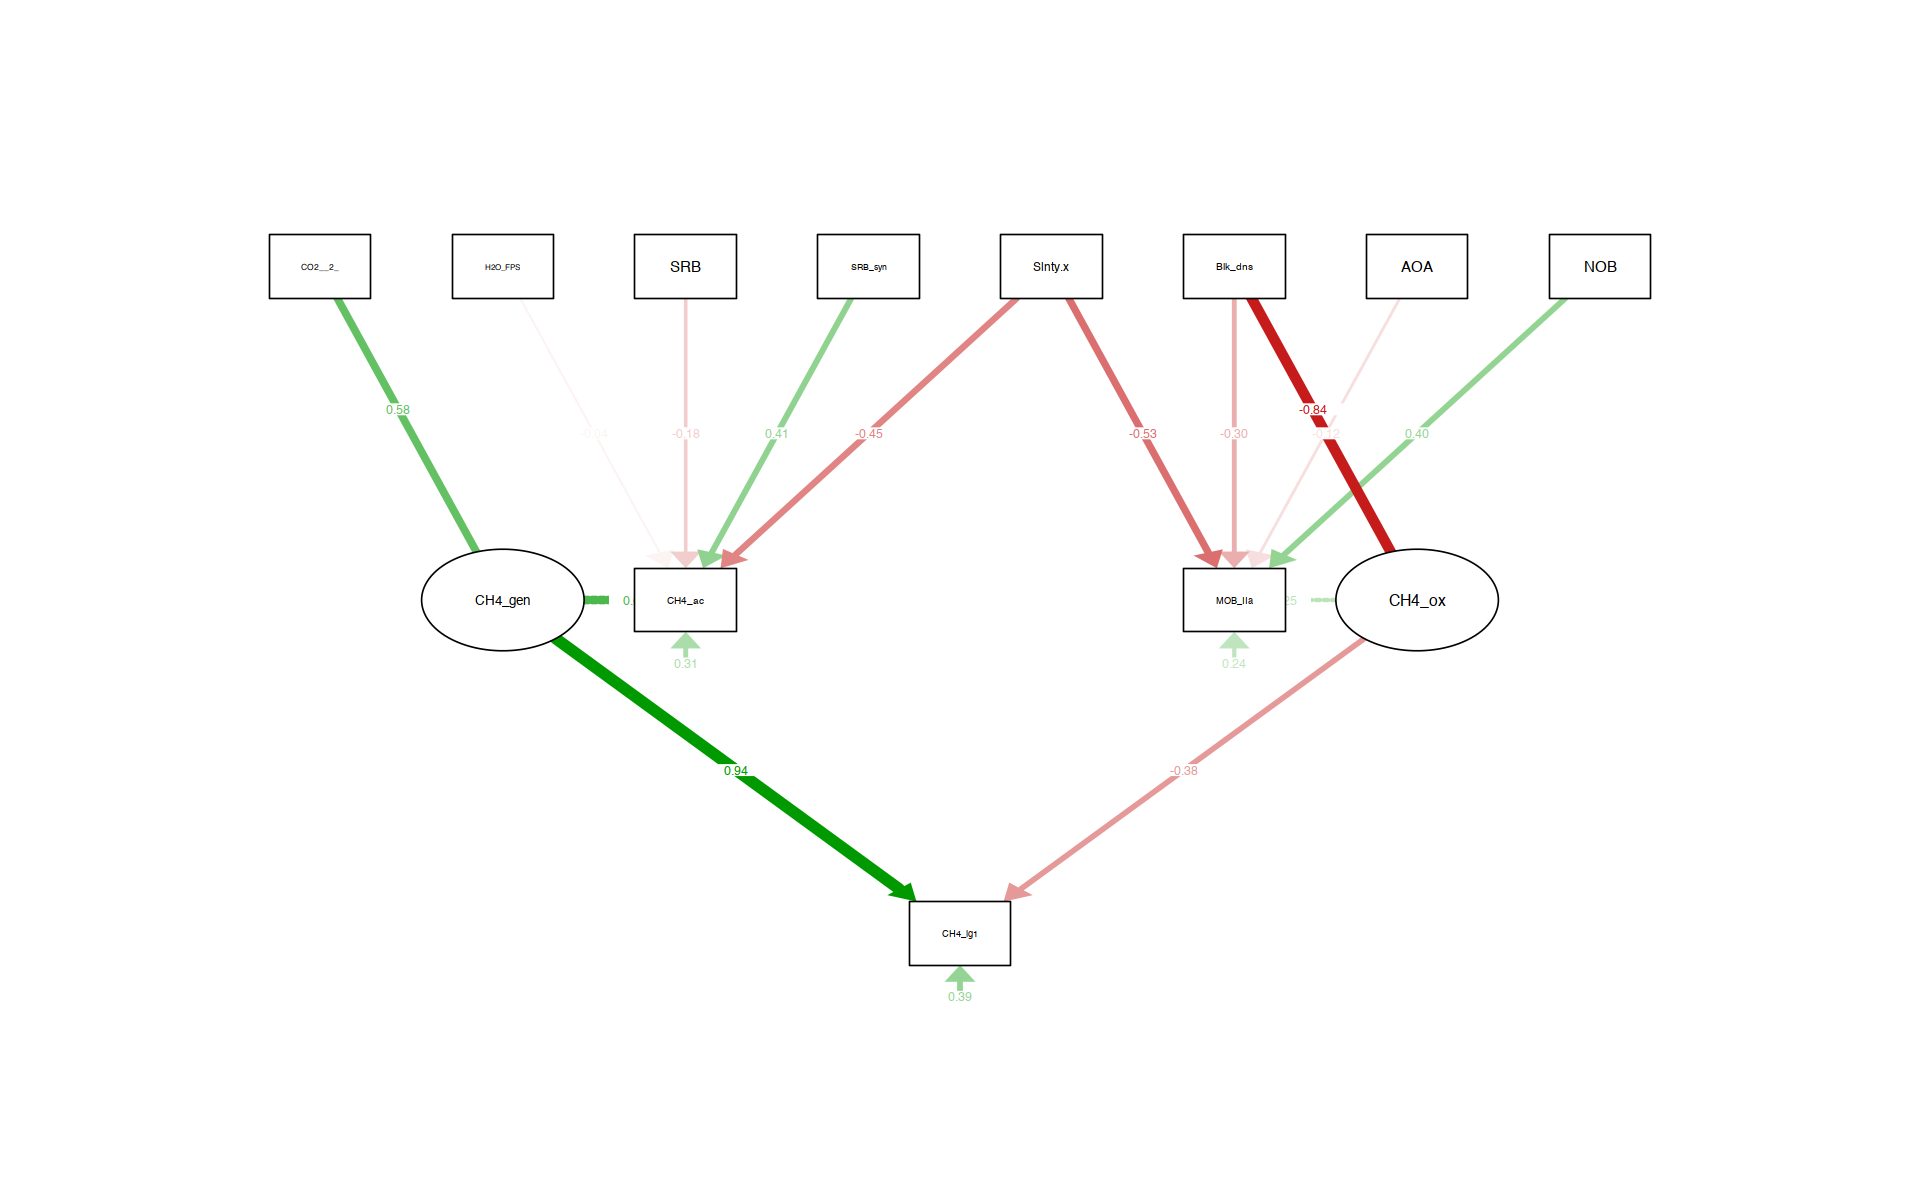

In [134]:
ch4at_1 <- 'CH4_logn1 ~ CH4_gen + CH4_ox
            CH4_gen <~ 1*CH4_ac + CO2_mg_m2_h
            CH4_ac  ~ H2O_FPS + SRB + SRB_syn + Salinity.x 
            CH4_ox <~ 1*MOB_IIa + Bulk_dens
            MOB_IIa  ~ Salinity.x + AOA + NOB + Bulk_dens'
ch4at_1.sem <- sem(ch4at_1, data=Guild_CH4, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
ch4at_1.sem
# Get summary of fit
sem_fit_sum(ch4at_1.sem, sem_fit_params)
# Get R2
get_SEM_R2s(ch4at_1.sem)
# Get non-significant vars
get_SEM_nonsig_vars(ch4at_1.sem, p_cut =0.05)
# Plot
options(repr.plot.width=16, repr.plot.height=10)  
semPaths(ch4at_1.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2', optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)

lavaan 0.6-11 ended normally after 49 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        10
                                                      
  Number of observations                            65
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                 6.265       5.179
  Degrees of freedom                                 5           5
  P-value (Chi-square)                           0.281       0.394
  Scaling correction factor                                  1.210
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ch4at_1_d.sem,0.281,6.265,5,10,306.178,327.922,0.989,0.993,0.993,0.062,0.017


model,CH4_logn1,MOB_IIa
<chr>,<dbl>,<dbl>
ch4at_1_d.sem,0.818,0.643


,lhs,op,rhs,pvalue
,<chr>,<chr>,<chr>,<dbl>
10,MOB_IIa,~,Bulk_dens,0.88


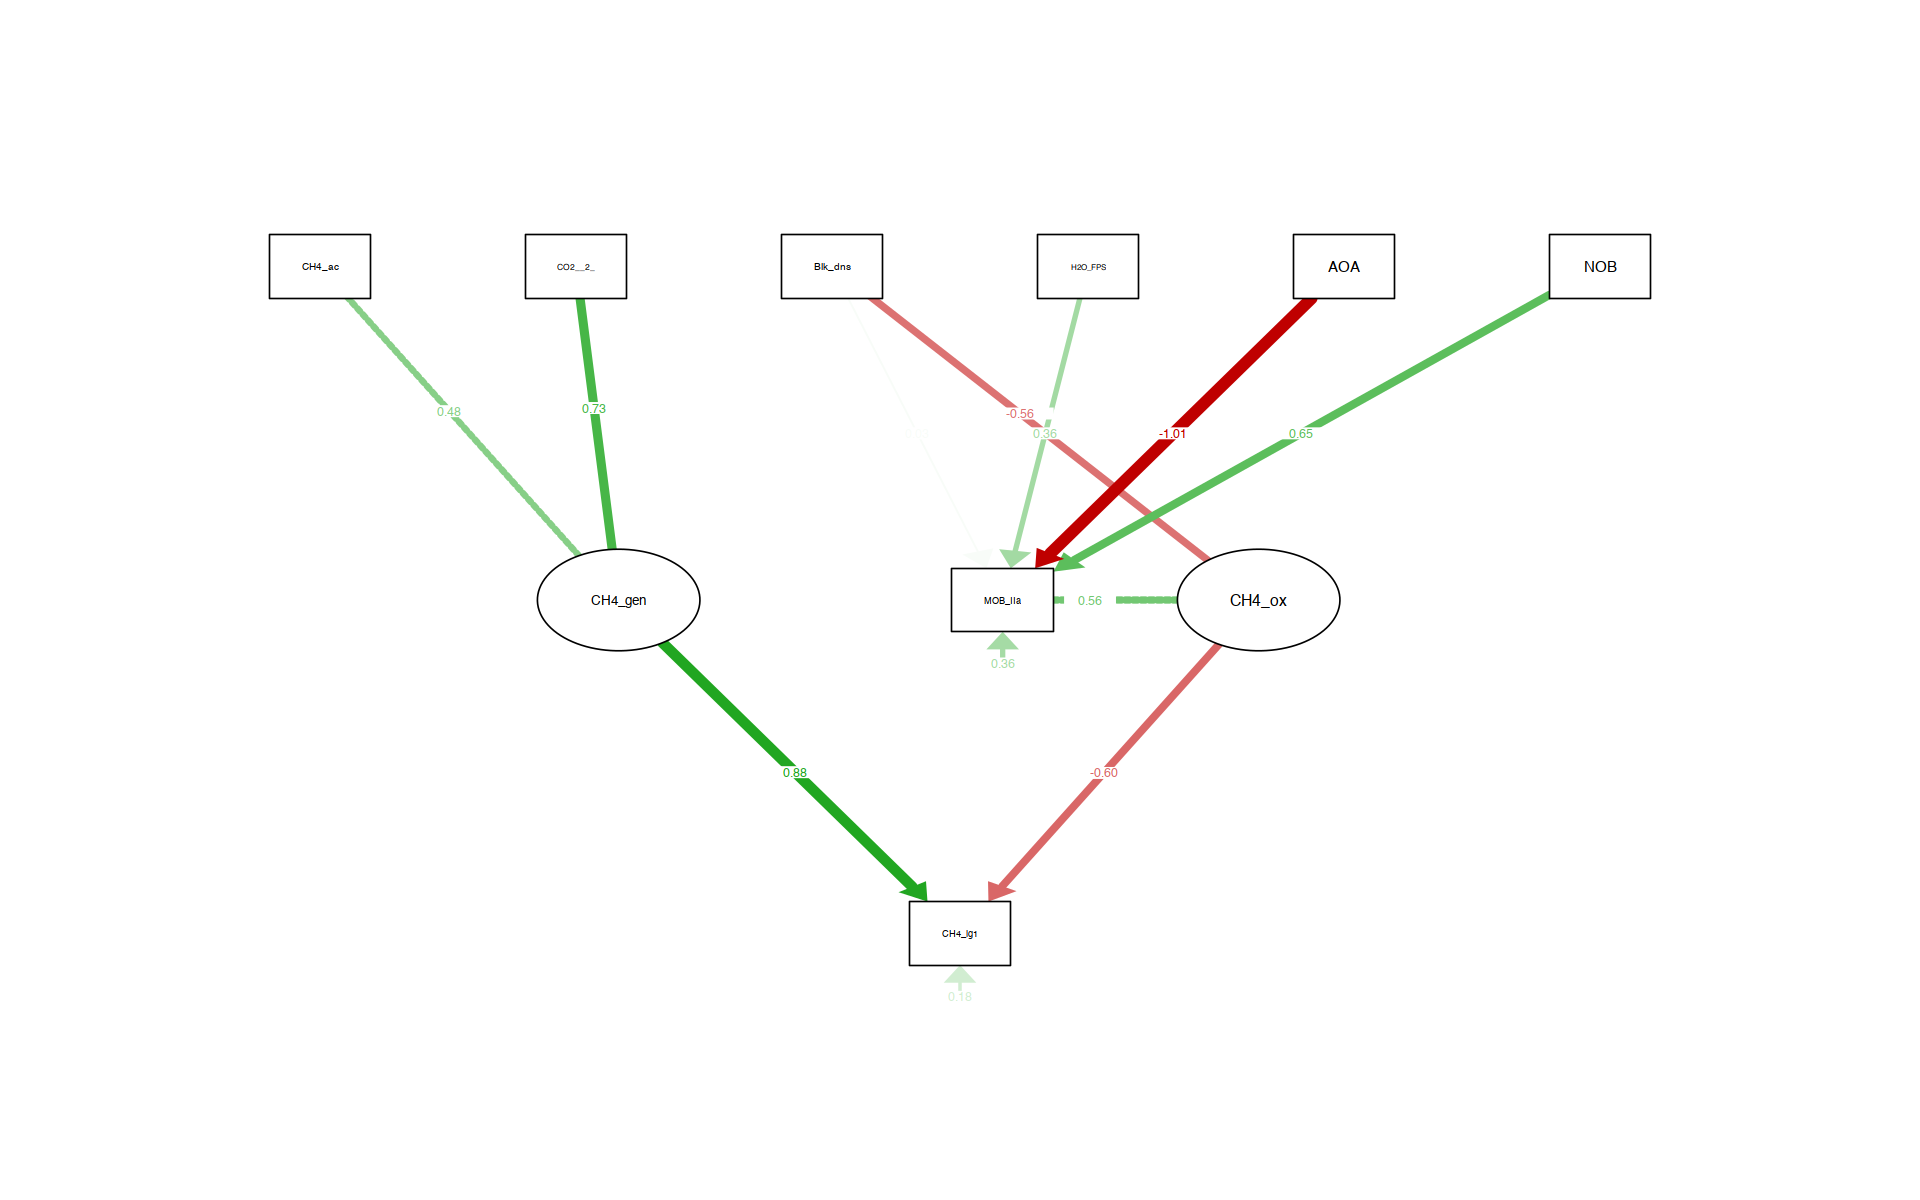

In [160]:
ch4at_1_d <- 'CH4_logn1 ~ CH4_gen + CH4_ox
            CH4_gen <~ 1*CH4_ac + CO2_mg_m2_h
            CH4_ox <~ 1*MOB_IIa + Bulk_dens
            MOB_IIa  ~ H2O_FPS + AOA + NOB + Bulk_dens'
ch4at_1_d.sem <- sem(ch4at_1_d, data=Guild_CH4_d, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
ch4at_1_d.sem
# Get summary of fit
sem_fit_sum(ch4at_1_d.sem, sem_fit_params)
# Get R2
get_SEM_R2s(ch4at_1_d.sem)
# Get non-significant vars
get_SEM_nonsig_vars(ch4at_1_d.sem, p_cut =0.05)
# Plot
options(repr.plot.width=16, repr.plot.height=10) 
Figure5b <- semPaths(ch4at_1_d.sem, 
                     "std", 
                     intercepts=FALSE, 
                     exoCov=F, 
                     curvePivot = TRUE, 
                     layout = 'tree2',
                     optimizeLatRes=T, 
                     style = "lisrel", 
                     reorder = FALSE, 
                     nCharNodes = 7) 

### Try Delta with same structure as all
- Result: Worse than original 5b, don't use

lavaan 0.6-11 ended normally after 62 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        15
                                                      
  Number of observations                            65
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                82.980      94.234
  Degrees of freedom                                15          15
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  0.881
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dmod.sem,0,82.98,15,15,547.004,579.619,0.904,0.779,0.779,0.264,0.039


model,CH4_logn1,CH4_ac,MOB_IIa
<chr>,<dbl>,<dbl>,<dbl>
dmod.sem,0.81,0.667,0.662


,lhs,op,rhs,pvalue
,<chr>,<chr>,<chr>,<dbl>
6,CH4_ac,~,SRB,0.21
8,CH4_ac,~,Salinity.x,0.36


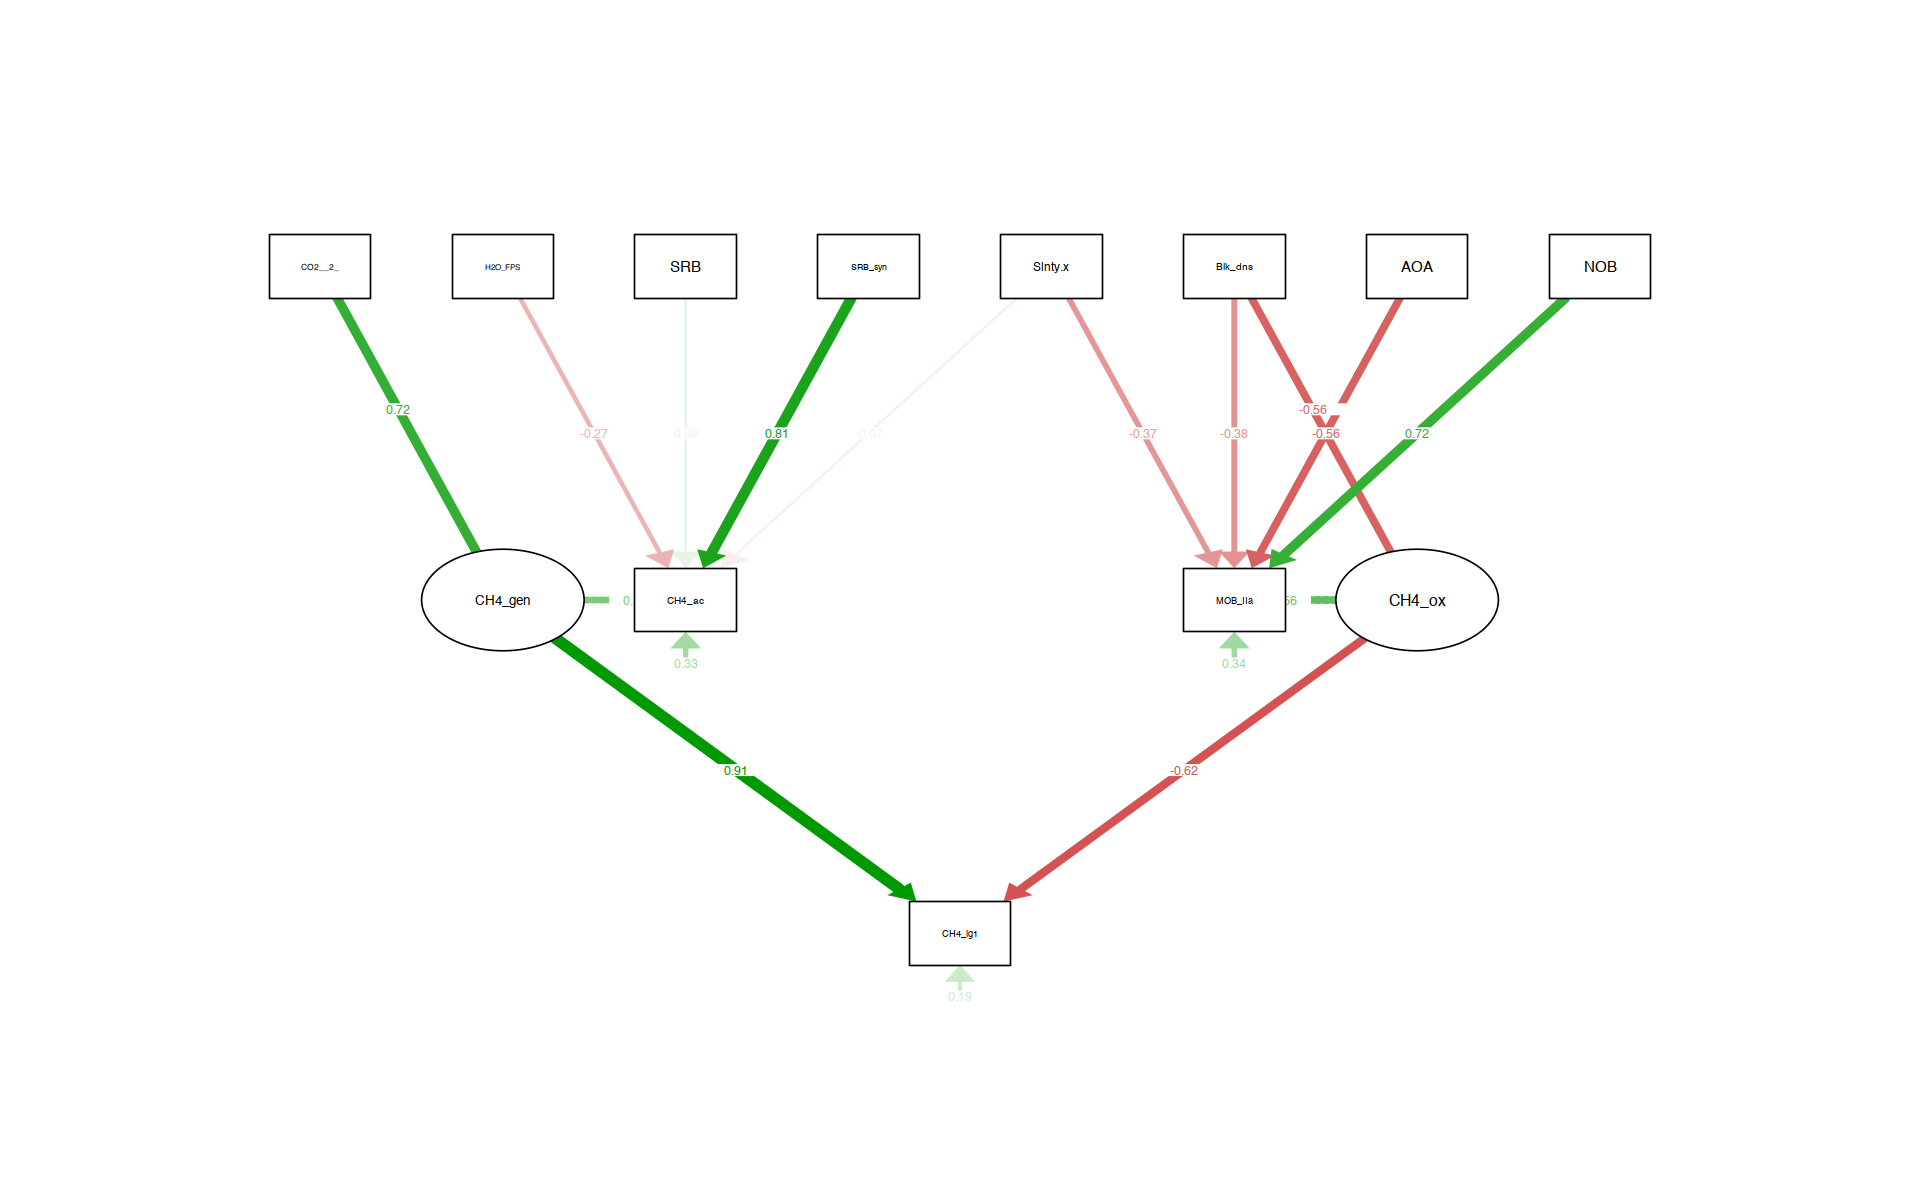

In [136]:
dmod <- 'CH4_logn1 ~ CH4_gen + CH4_ox
            CH4_gen <~ 1*CH4_ac + CO2_mg_m2_h
            CH4_ac  ~ H2O_FPS + SRB + SRB_syn + Salinity.x 
            CH4_ox <~ 1*MOB_IIa + Bulk_dens
            MOB_IIa  ~ Salinity.x + AOA + NOB + Bulk_dens'
dmod.sem <- sem(dmod, data=Guild_CH4_d, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
dmod.sem
sem_fit_sum(dmod.sem, sem_fit_params)
get_SEM_R2s(dmod.sem)
get_SEM_nonsig_vars(dmod.sem, p_cut =0.05)
options(repr.plot.width=16, repr.plot.height=10) 
semPaths(dmod.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2',optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)

## 3. Alternatives
- Figure 5a model no longer significant
- 1. Try summing all methanogens and all MOB. Result: Not significant
- 2. Try alternative models specified by Wyatt in Table S10. Result:

### 3a. With CH4_all and MOB_all

lavaan 0.6-11 ended normally after 59 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        15
                                                      
  Number of observations                           152
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                49.815      54.709
  Degrees of freedom                                15          15
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  0.911
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod.sem,0,49.815,15,15,1248.531,1293.889,0.968,0.928,0.928,0.124,0.04


model,CH4_logn1,CH4_all,MOB_all
<chr>,<dbl>,<dbl>,<dbl>
mod.sem,0.59,0.779,0.473


,lhs,op,rhs,pvalue
,<chr>,<chr>,<chr>,<dbl>
5,CH4_all,~,H2O_FPS,0.70
14,MOB_all,~,Bulk_dens,0.11


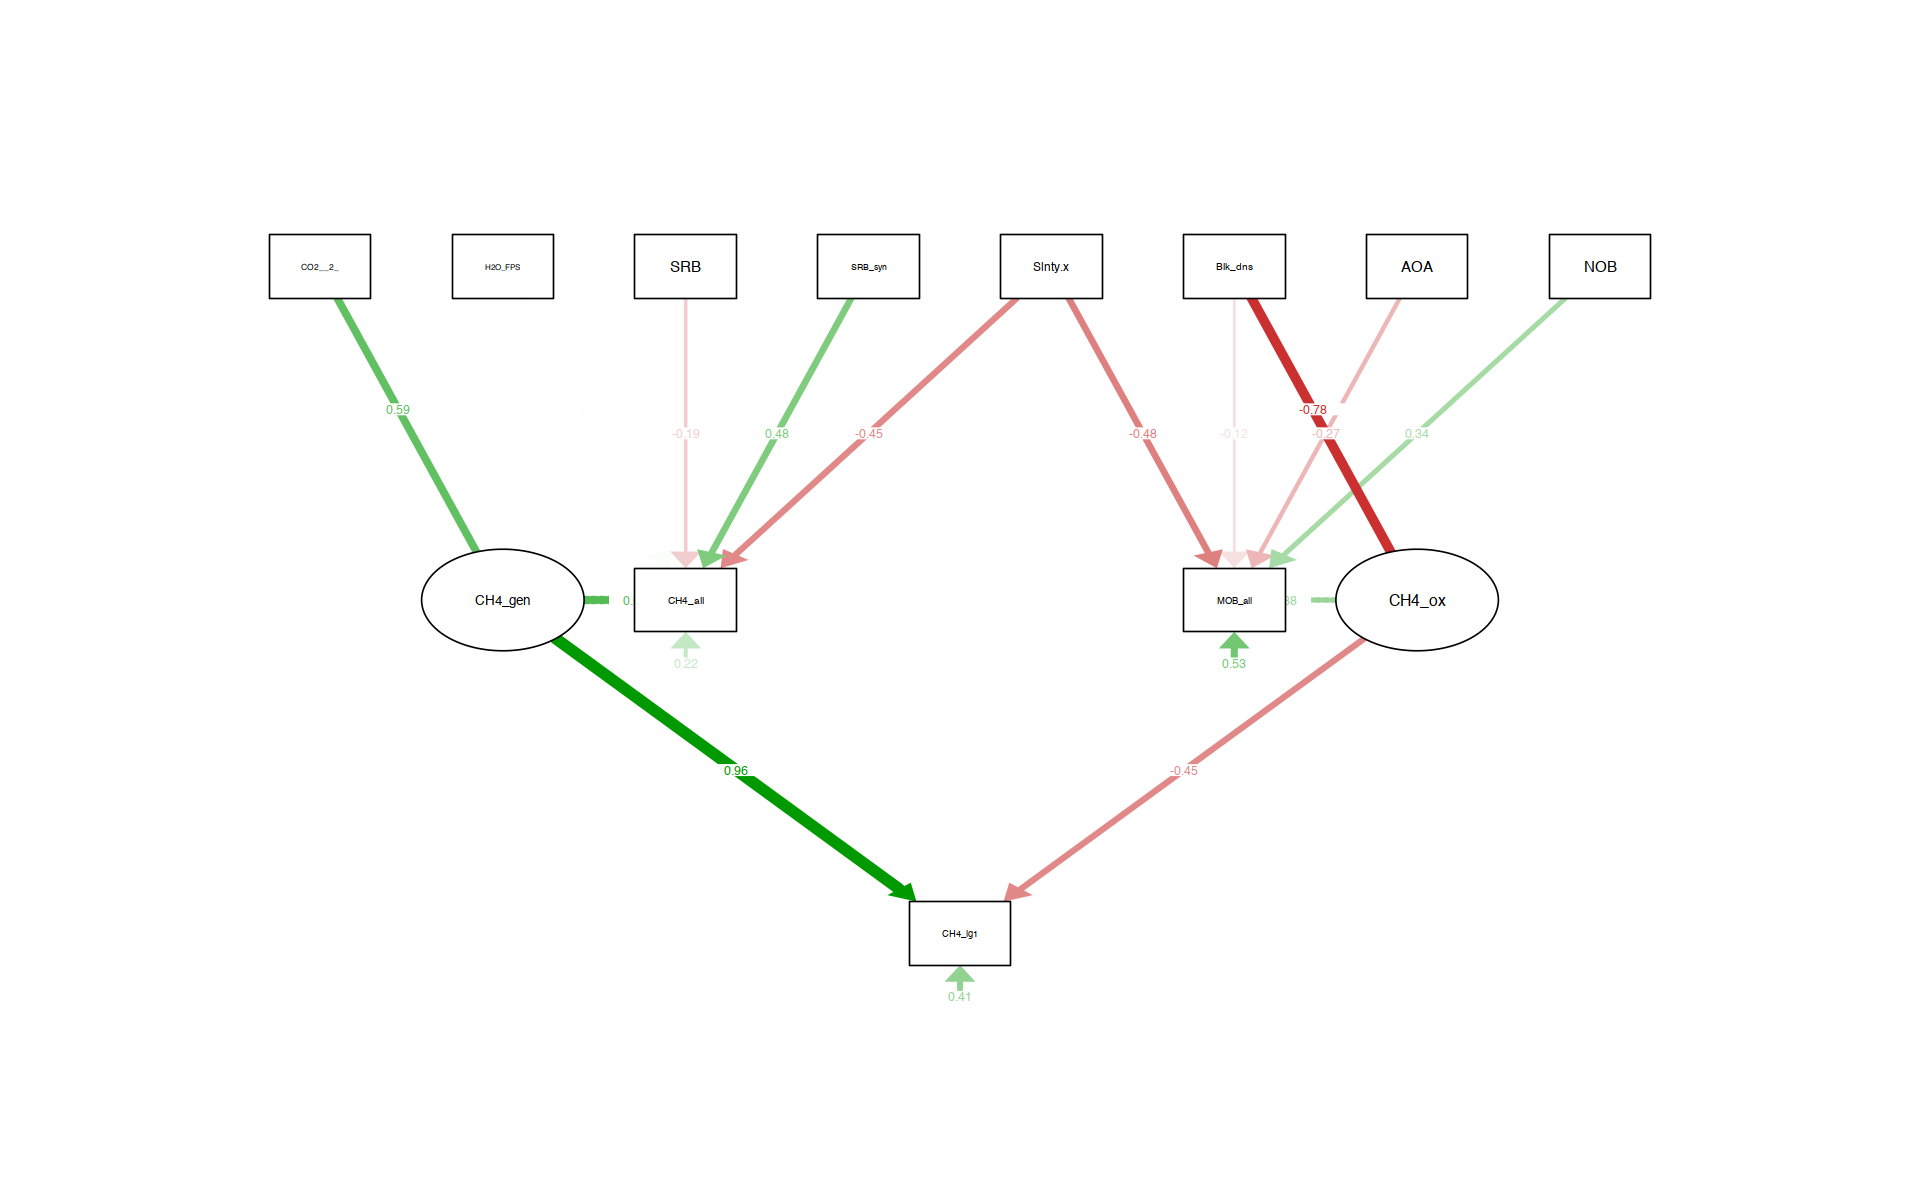

In [137]:
mod <- 'CH4_logn1 ~ CH4_gen + CH4_ox
        CH4_gen <~ 1*CH4_all + CO2_mg_m2_h
        CH4_all  ~ H2O_FPS + SRB + SRB_syn + Salinity.x 
        CH4_ox <~ 1*MOB_all + Bulk_dens
        MOB_all  ~ Salinity.x + AOA + NOB + Bulk_dens'
mod.sem <- sem(mod, data=Guild_CH4, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
mod.sem
sem_fit_sum(mod.sem, sem_fit_params)
get_SEM_R2s(mod.sem)
get_SEM_nonsig_vars(mod.sem, p_cut =0.05)
options(repr.plot.width=16, repr.plot.height=10) 
semPaths(mod.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2',optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)

lavaan 0.6-11 ended normally after 46 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        10
                                                      
  Number of observations                            65
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                10.898       8.852
  Degrees of freedom                                 5           5
  P-value (Chi-square)                           0.053       0.115
  Scaling correction factor                                  1.231
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dmod.sem,0.053,10.898,5,10,208.868,230.612,0.979,0.962,0.962,0.135,0.023


model,CH4_logn1,MOB_all
<chr>,<dbl>,<dbl>
dmod.sem,0.785,0.58


lhs,op,rhs,pvalue
<chr>,<chr>,<chr>,<dbl>


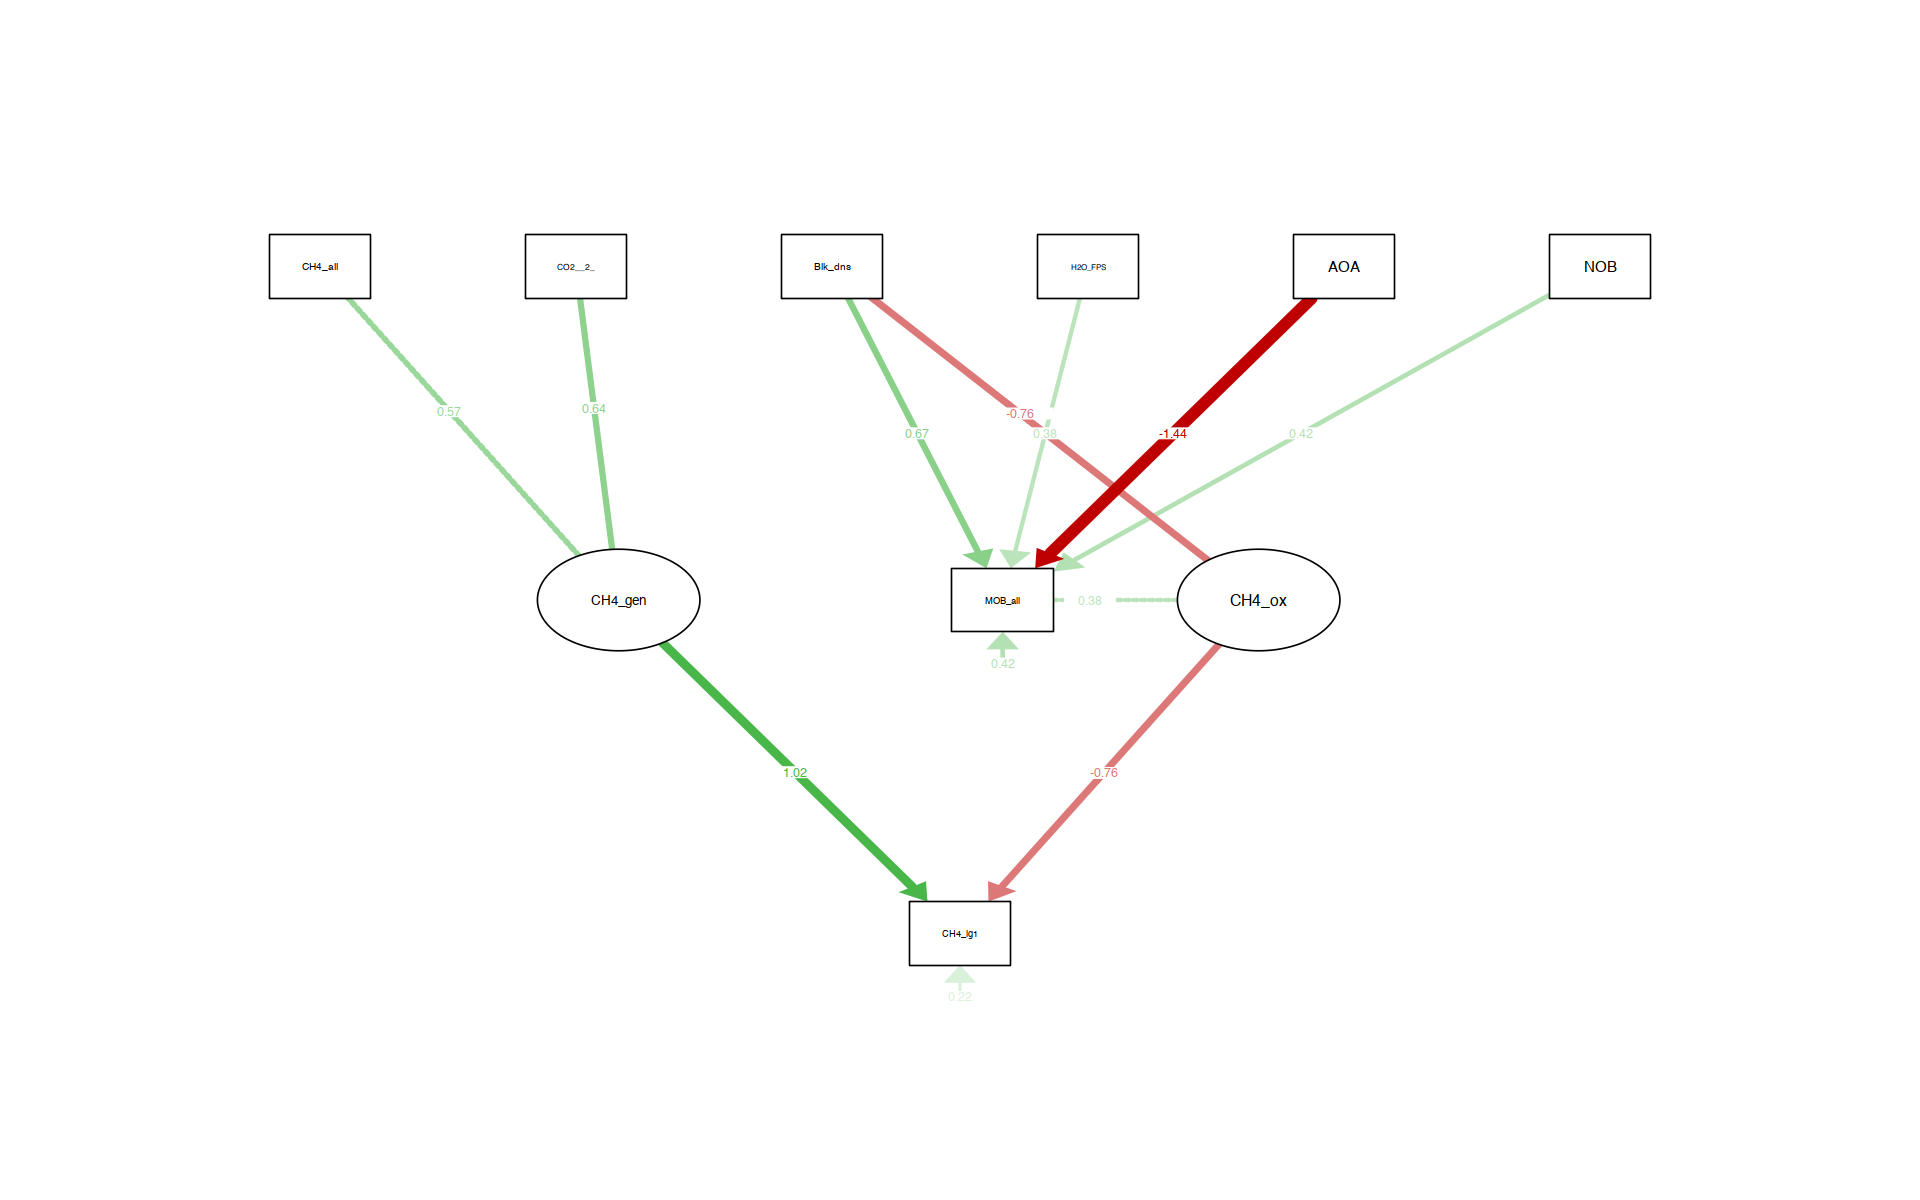

In [138]:
dmod <- 'CH4_logn1 ~ CH4_gen + CH4_ox
         CH4_gen <~ 1*CH4_all + CO2_mg_m2_h
         CH4_ox <~ 1*MOB_all + Bulk_dens
         MOB_all  ~ H2O_FPS + AOA + NOB + Bulk_dens'
dmod.sem <- sem(dmod, data=Guild_CH4_d, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
dmod.sem
sem_fit_sum(dmod.sem, sem_fit_params)
get_SEM_R2s(dmod.sem)
get_SEM_nonsig_vars(dmod.sem, p_cut =0.05)
options(repr.plot.width=16, repr.plot.height=10) 
semPaths(dmod.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2',optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)

### 3b. More alternative models
- From Table S10

lavaan 0.6-11 ended normally after 71 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        15
                                                      
  Number of observations                           152
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                42.007      44.420
  Degrees of freedom                                15          15
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  0.946
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod.sem,0,42.007,15,15,1513.703,1559.061,0.982,0.951,0.951,0.109,0.03


model,CH4_logn1,CH4_ac,MOB_IIa
<chr>,<dbl>,<dbl>,<dbl>
mod.sem,0.606,0.69,0.759


,lhs,op,rhs,pvalue
,<chr>,<chr>,<chr>,<dbl>
2,CH4_logn1,~,CH4_ox,0.13
8,CH4_ac,~,H2O_FPS,0.41
10,CH4_ox,<~,Bulk_dens,0.17
12,MOB_IIa,~,AOA,0.10


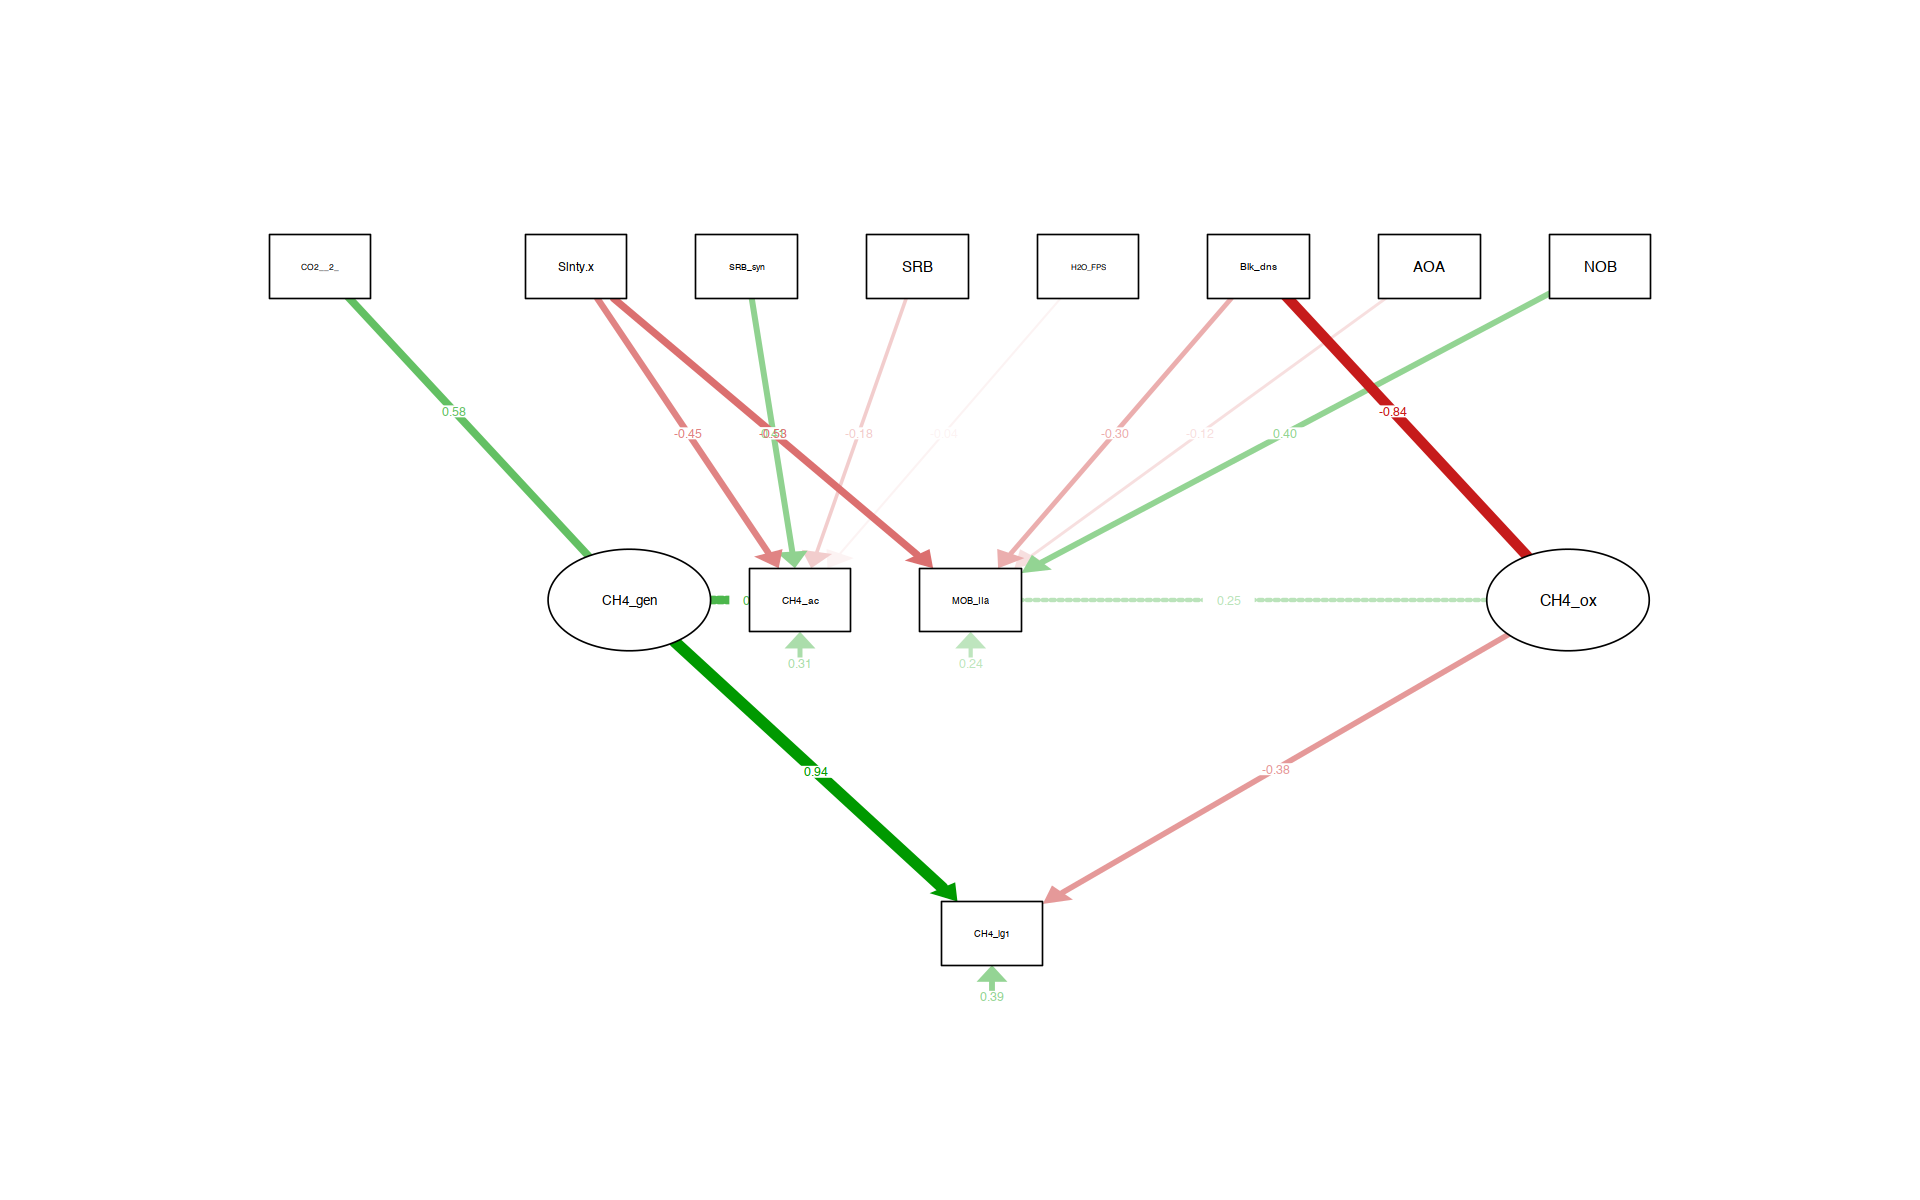

In [147]:
# Try all 7 models in Table S10 here (all that changes is CH4_ac term)
# None significant
mod <- 'CH4_logn1 ~ CH4_gen + CH4_ox
        CH4_gen <~ 1*CH4_ac + CO2_mg_m2_h
        CH4_ac  ~ Salinity.x + SRB_syn + SRB + H2O_FPS
        CH4_ox <~ 1*MOB_IIa + Bulk_dens
        MOB_IIa  ~ Salinity.x + AOA + NOB + Bulk_dens'
mod.sem <- sem(mod, data=Guild_CH4, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
mod.sem
sem_fit_sum(mod.sem, sem_fit_params)
get_SEM_R2s(mod.sem)
get_SEM_nonsig_vars(mod.sem, p_cut =0.05)
options(repr.plot.width=16, repr.plot.height=10) 
semPaths(mod.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2',optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)

## 4. Combined CH4_ac + CH4_Mix
- This was a major change in the update, so makes sense to test. Plus Methanosarcinaceae can perform ac which is what Wyatt had before
- CH4_ac_mix is the summed variable
- Use this for new Figure 5

lavaan 0.6-11 ended normally after 62 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        15
                                                      
  Number of observations                           152
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                43.524      44.774
  Degrees of freedom                                15          15
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  0.972
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod.sem,0,43.524,15,15,1459.705,1505.063,0.985,0.952,0.952,0.112,0.035


model,CH4_logn1,CH4_ac_mix,MOB_IIa
<chr>,<dbl>,<dbl>,<dbl>
mod.sem,0.613,0.764,0.759


,lhs,op,rhs,pvalue
,<chr>,<chr>,<chr>,<dbl>
5,CH4_ac_mix,~,H2O_FPS,0.91
12,MOB_IIa,~,AOA,0.10


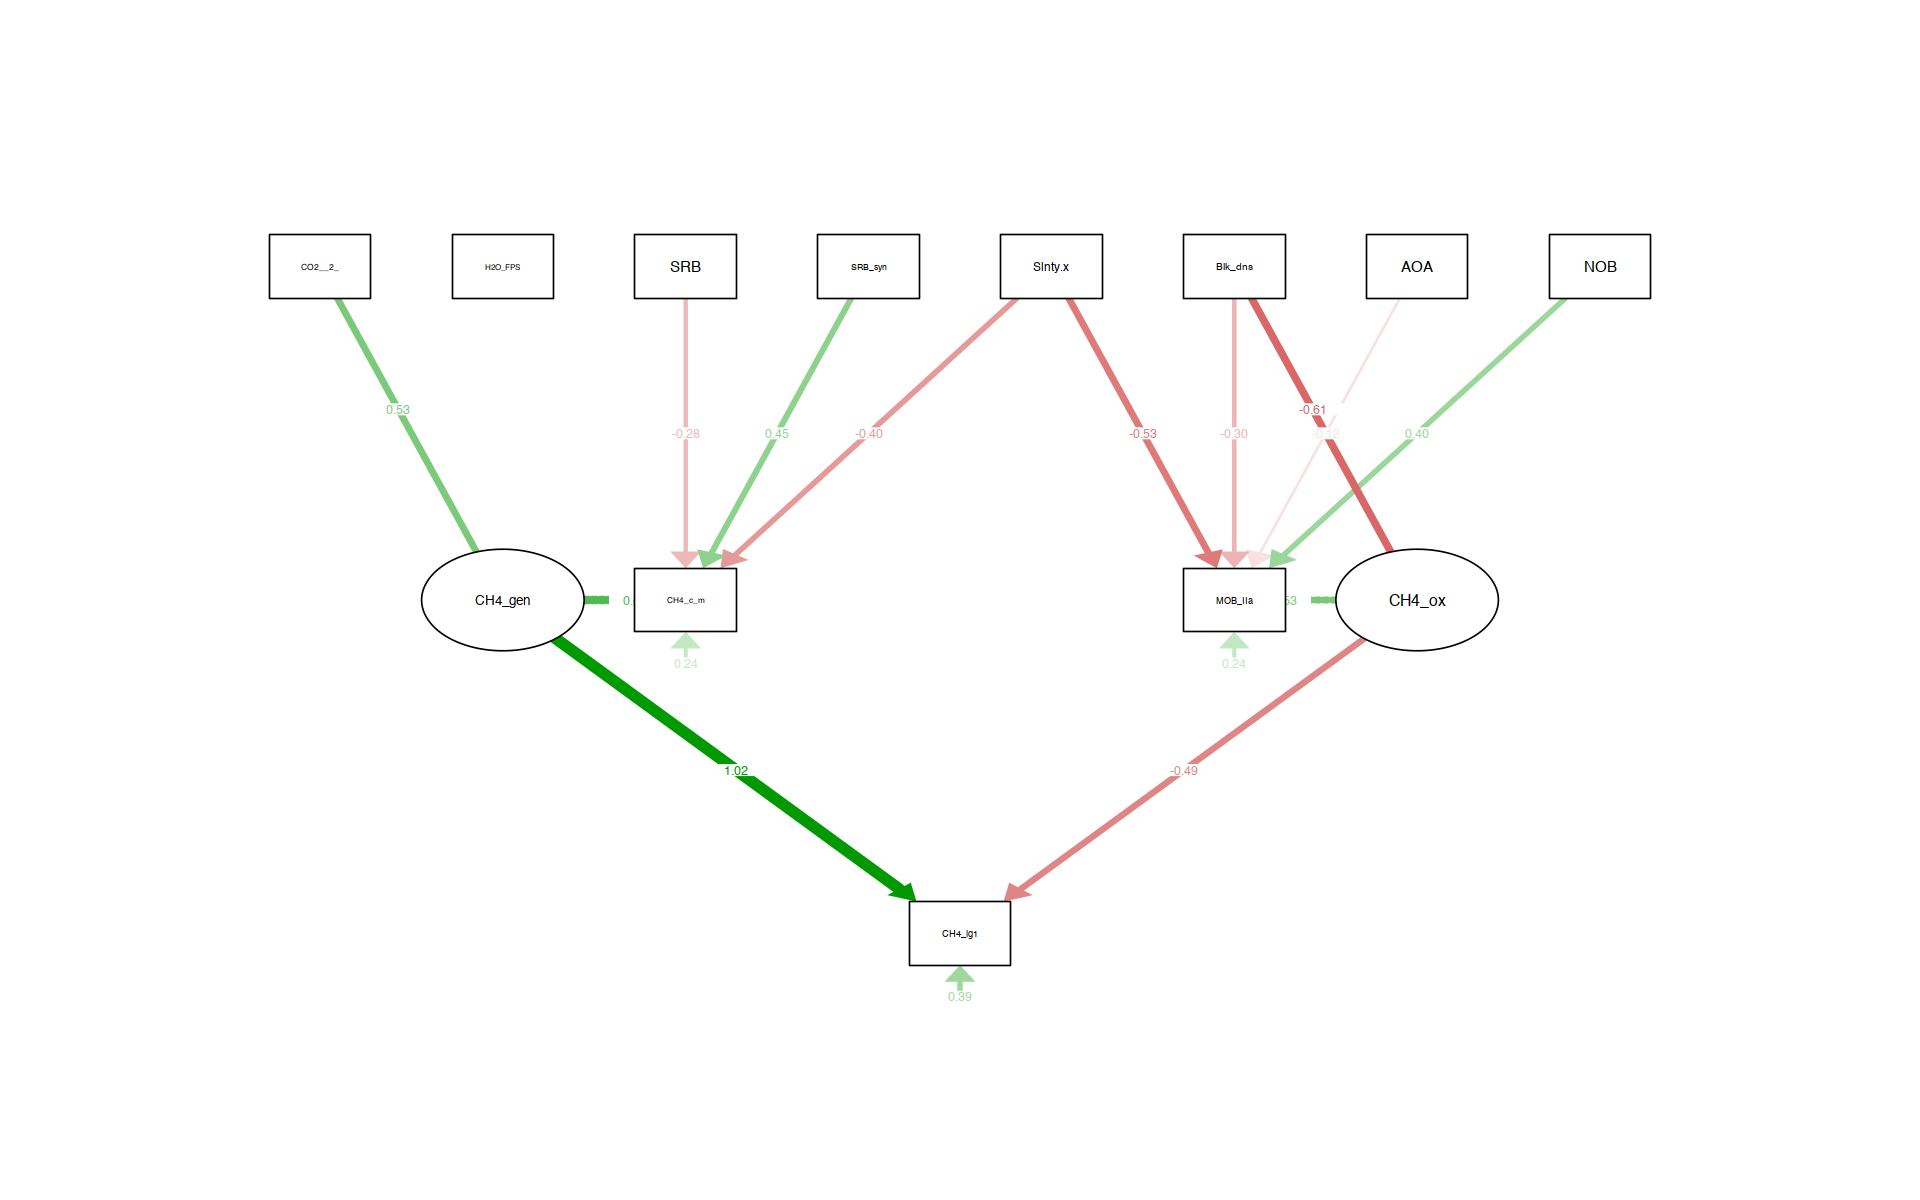

In [148]:
mod <- 'CH4_logn1 ~ CH4_gen + CH4_ox
        CH4_gen <~ 1*CH4_ac_mix + CO2_mg_m2_h
        CH4_ac_mix  ~ H2O_FPS + SRB + SRB_syn + Salinity.x 
        CH4_ox <~ 1*MOB_IIa + Bulk_dens
        MOB_IIa  ~ Salinity.x + AOA + NOB + Bulk_dens'
mod.sem <- sem(mod, data=Guild_CH4, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
mod.sem
sem_fit_sum(mod.sem, sem_fit_params)
get_SEM_R2s(mod.sem)
get_SEM_nonsig_vars(mod.sem, p_cut =0.05)
options(repr.plot.width=16, repr.plot.height=10) 
semPaths(mod.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2',optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)

lavaan 0.6-11 ended normally after 50 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        10
                                                      
  Number of observations                            65
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                 6.703       7.031
  Degrees of freedom                                 5           5
  P-value (Chi-square)                           0.244       0.218
  Scaling correction factor                                  0.953
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod.sem,0.244,6.703,5,10,300.607,322.351,0.99,0.99,0.99,0.072,0.019


model,CH4_logn1,MOB_IIa
<chr>,<dbl>,<dbl>
mod.sem,0.837,0.643


,lhs,op,rhs,pvalue
,<chr>,<chr>,<chr>,<dbl>
10,MOB_IIa,~,Bulk_dens,0.88


pdf 
  2

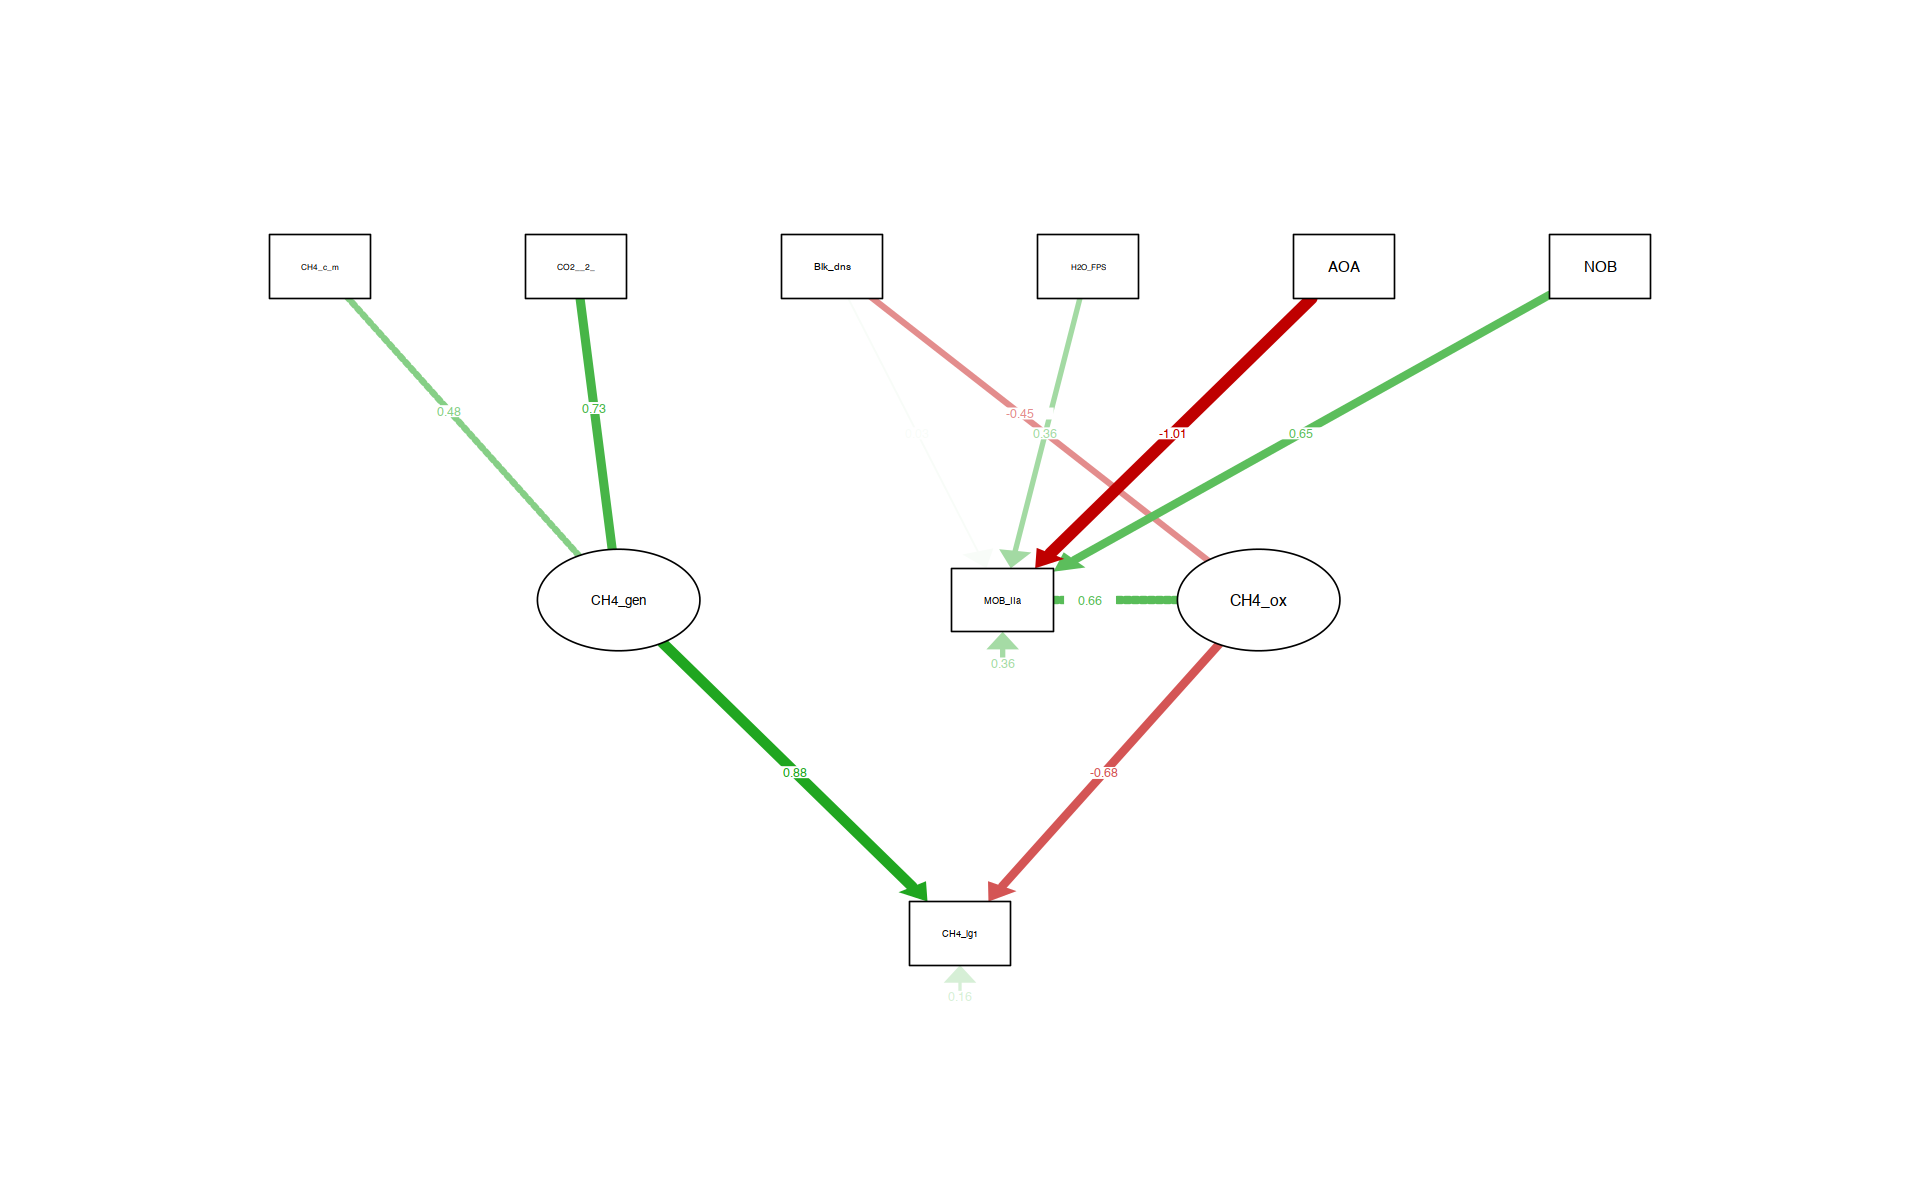

In [163]:
dmod <- 'CH4_logn1 ~ CH4_gen + CH4_ox
            CH4_gen <~ 1*CH4_ac_mix + CO2_mg_m2_h
            CH4_ox <~ 1*MOB_IIa + Bulk_dens
            MOB_IIa  ~ H2O_FPS + AOA + NOB + Bulk_dens'
mod.sem <- sem(dmod, data=Guild_CH4_d, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
mod.sem
sem_fit_sum(mod.sem, sem_fit_params)
get_SEM_R2s(mod.sem)
get_SEM_nonsig_vars(mod.sem, p_cut =0.05)
options(repr.plot.width=16, repr.plot.height=10)
pdf("Figure5.pdf", width = 8, height = 6)
semPaths(mod.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2',optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)
dev.off()
semPaths(mod.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2',optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)

## 5. Model for non-Delta
- Idea is that gradient is so big, could be non-linearities causing lack of sig. model in all data
- We have Delta model, so what about non-Delta model for the more saline part of the gradient

lavaan 0.6-11 ended normally after 65 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        12
                                                      
  Number of observations                            87
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                                65.013      64.195
  Degrees of freedom                                 9           9
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.013
       Satorra-Bentler correction                                 

model,pvalue,chisq,df,npar,aic,bic,gfi,cfi,rni,rmsea,srmr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
modb.sem,0,65.013,9,12,845.533,875.124,0.846,0.738,0.738,0.267,0.09


model,CH4_logn1,CH4_ac_mix,MOB_IIa
<chr>,<dbl>,<dbl>,<dbl>
modb.sem,0.313,0.443,0.606


,lhs,op,rhs,pvalue
,<chr>,<chr>,<chr>,<dbl>
1,CH4_logn1,~,CH4_gen,0.23
4,CH4_gen,<~,CO2_mg_m2_h,0.72
7,CH4_ox,<~,Bulk_dens,0.21
9,MOB_IIa,~,AOA,0.79
10,MOB_IIa,~,NOB,0.33


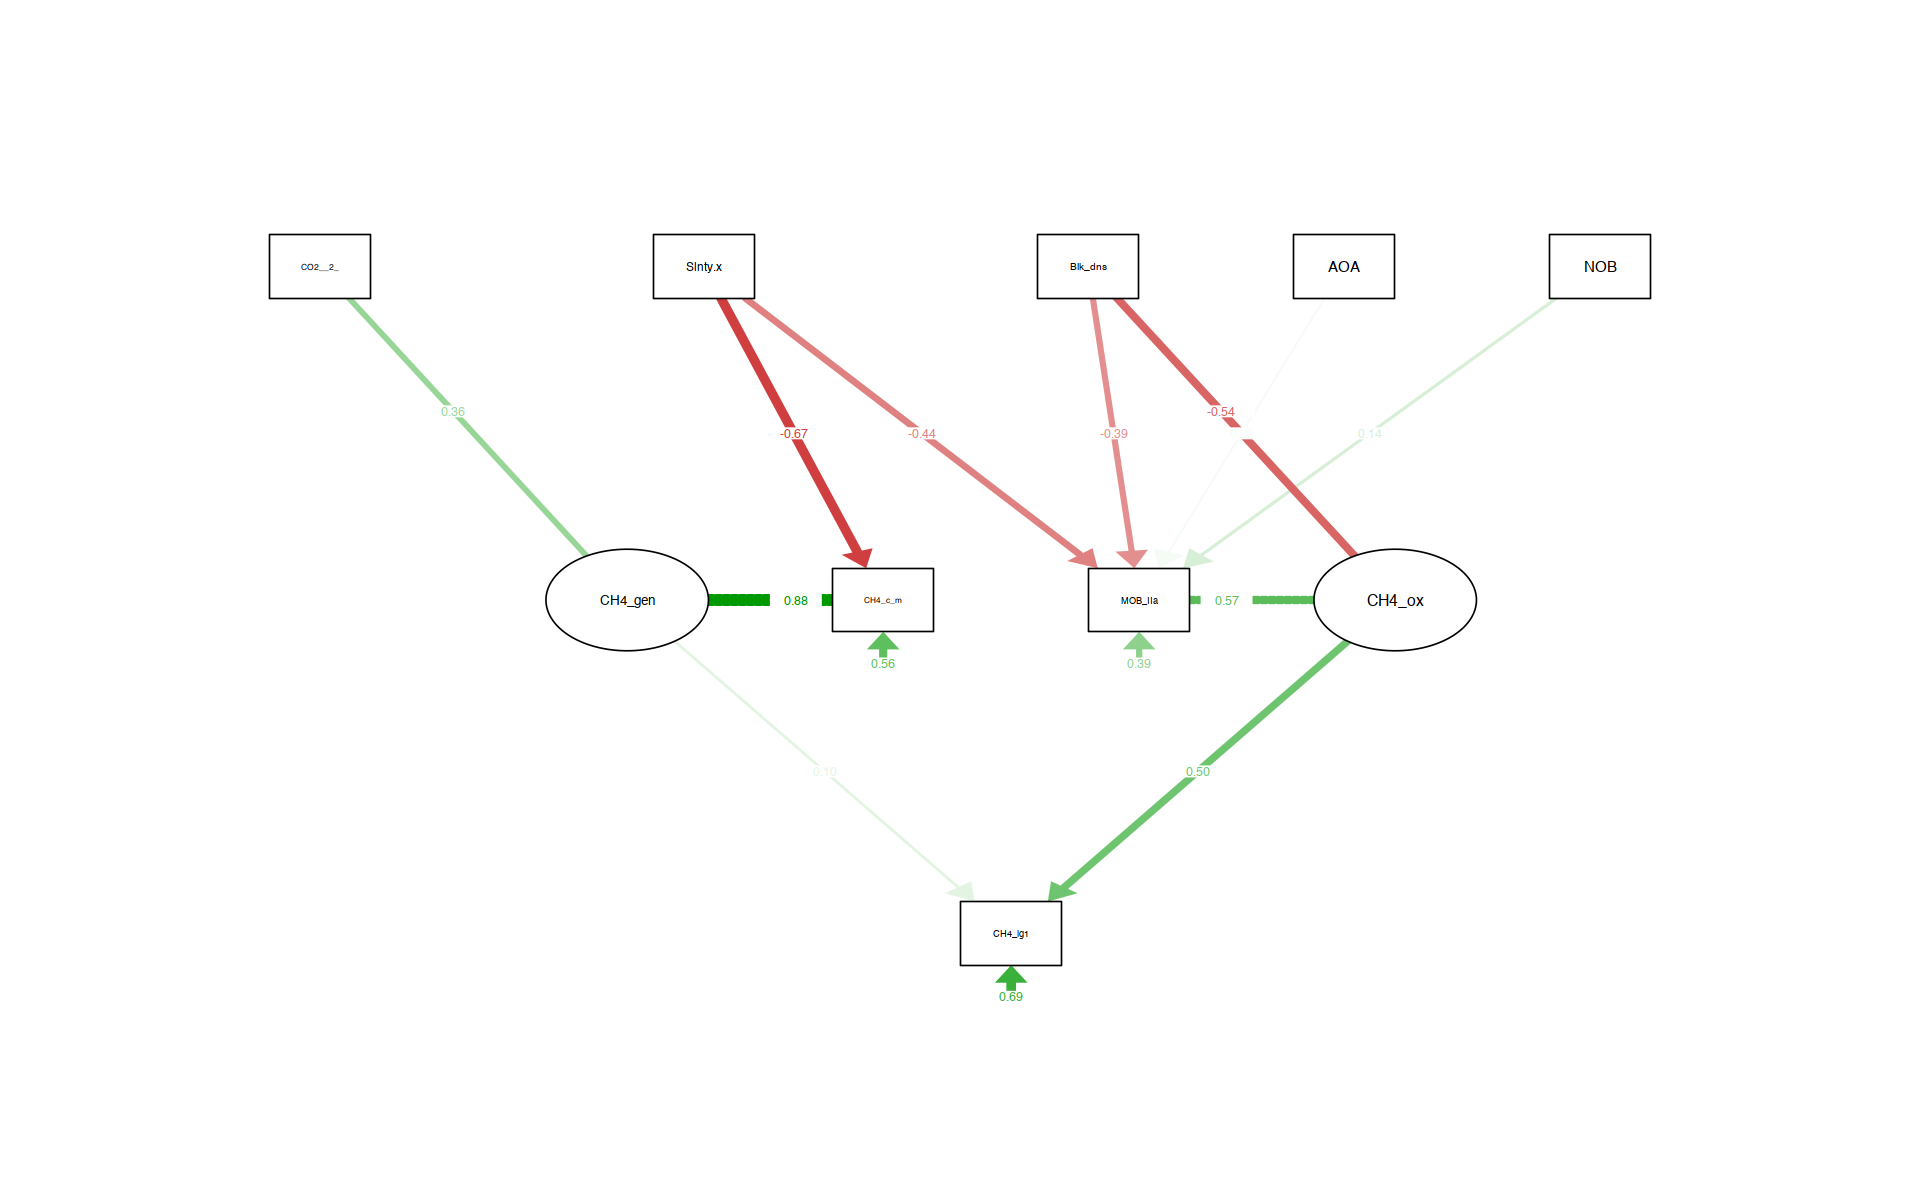

In [177]:
# Run for Delta model and top 8 all data models 
modb <- 'CH4_logn1 ~ CH4_gen + CH4_ox
            CH4_gen <~ 1*CH4_ac_mix + CO2_mg_m2_h
            CH4_ac_mix  ~ Salinity.x
            CH4_ox <~ 1*MOB_IIa + Bulk_dens
            MOB_IIa  ~ Salinity.x + AOA + NOB + Bulk_dens'
modb.sem <- sem(modb, data=Guild_CH4_b, fixed.x=TRUE, orthogonal=TRUE, estimator ="mlm")
modb.sem
# Get summary of fit
sem_fit_sum(modb.sem, sem_fit_params)
# Get R2
get_SEM_R2s(modb.sem)
# Get non-significant vars
get_SEM_nonsig_vars(modb.sem, p_cut =0.05)
# Plot
options(repr.plot.width=16, repr.plot.height=10)  
semPaths(modb.sem, "std", intercepts=FALSE, exoCov=F, curvePivot = TRUE, layout = 'tree2', optimizeLatRes=T, 
         style = "lisrel", reorder = FALSE, nCharNodes = 7)